# **06 - PRESENTATION: Nothing But Net**

In [1]:
from IPython.display import Image
Image(url='https://secure.nba.com/assets/amp/include/images/nba-logo.png', height = 300, width = 800)

## **The Dataset**

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import urllib.request
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact, interactive, fixed
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

### **NBA SHOT LOG DATA 2014-2015**

In [3]:
data = pd.read_csv('/data/chiragnarayanakere/dansbecker/nba-shot-logs/shot_logs.csv')
data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


**Dataset length and columns**

In [4]:
print("There are " + str(len(data.columns)) + " columns and " + str(len(data)) + " rows")

There are 21 columns and 128069 rows


## **Tidying the Dataset**

* Filtered for Shot Distances <= 24
* Filtered for Periods <= 4
* Dropped all NaN values
* Added a column called 'mademissnum' which correlated to Shot Result 
    * 1 for Made, 0 for Missed
* Selected 7 metrics which I believe would be the best predictors of Shot Result

In [5]:
tidydata = pd.read_csv('/data/chiragnarayanakere/NewNBA.csv')
tidydata = tidydata.drop('Unnamed: 0', 1)
tidydata.head()

,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,mademissnum
0,1,10.8,2,1.9,7.7,2,made,1.3,1
1,2,10.3,2,1.9,17.2,2,missed,3.4,0
2,2,10.9,2,2.7,3.7,2,missed,1.1,0
3,2,9.1,2,4.4,18.4,2,missed,2.6,0
4,4,14.5,11,9.0,20.7,2,missed,6.1,0


## **Exploratory Data Analysis**

In [6]:
data = data.loc[(data['PERIOD'] <= 4)]
data = data.dropna()
data.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148
5,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,6,2,8:15,9.1,2,...,18.4,2,missed,"Williams, Deron",101114,2.6,0,0,brian roberts,203148


## Does shot distance affect whether or not the shot goes in?

Text(0.5,1,'Probablity of Basket vs. Distance from Basket')

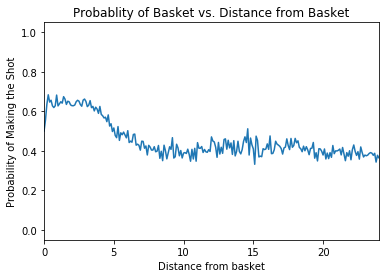

In [7]:
(pd.crosstab(data['SHOT_DIST'], data['SHOT_RESULT'], normalize='index').loc[:, 'made']).plot()
plt.xlim(0, 24)
plt.ylabel('Probability of Making the Shot')
plt.xlabel('Distance from basket')
plt.title("Probablity of Basket vs. Distance from Basket")

## Does the amount of time left on the shot clock determine whether or not the shot goes in?

Text(0.5,1,'Probablity of Basket vs. Shot Clock')

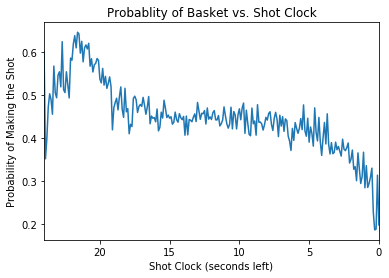

In [8]:
(pd.crosstab(data['SHOT_CLOCK'], data['SHOT_RESULT'], normalize='index').loc[:, 'made']).plot()
plt.ylabel('Probability of Making the Shot')
plt.xlabel('Shot Clock (seconds left)')
plt.xlim(24, 0)
plt.title("Probablity of Basket vs. Shot Clock")

## Who has made the most shots?

In [9]:
playerscount = data.groupby(['player_name'])['FGM'].count()

The player who has made the most shots is JAMES HARDEN with 997 shots!


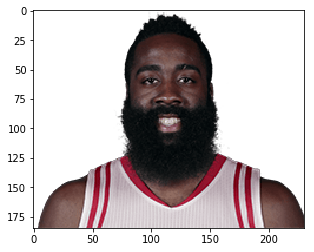

In [10]:
print("The player who has made the most shots is " + 
      str(playerscount.idxmax().upper()) + " with " + str(playerscount.max()) + " shots!")
pic = urllib.request.urlretrieve("http://stats.nba.com/media/players/230x185/201935.png")
harden_pic = plt.imread(pic[0])
plt.imshow(harden_pic)
plt.show()

## Who has made the most 3-pointers?

In [11]:
threeptrs = data.loc[data['PTS_TYPE'] == 3]

In [12]:
threecount = threeptrs.groupby(['player_name'])['PTS_TYPE'].count()

The player who has made the most 3-Ptrs is STEPHEN CURRY with 433 3-pointers!


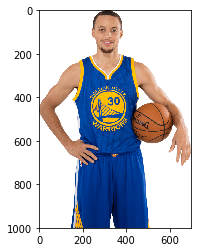

In [13]:
print("The player who has made the most 3-Ptrs is " + 
      str(threecount.idxmax().upper()) + " with " + str(threecount.max()) + " 3-pointers!")
pic = urllib.request.urlretrieve("http://www.stickpng.com/assets/images/584563b767f531417746b915.png")
curry_pic = plt.imread(pic[0])
plt.imshow(curry_pic)
plt.show()

## Who is the clutchest player? 

** "Clutchness" is calculated by how many shots a player has made in the last quarter of a game**

In [14]:
clutch = data.loc[(data['PERIOD'] == 4)]

In [15]:
clutchshot = clutch.groupby(['player_name'])['FGM'].count()

The player who is the clutchest is DAMIAN LILLARD with 264 shots made in the 4th quarter!


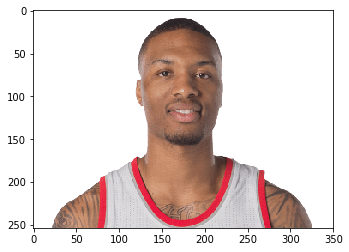

In [16]:
print("The player who is the clutchest is " + 
      str(clutchshot.idxmax().upper()) + " with " + str(clutchshot.max()) + " shots made in the 4th quarter!")
pic = urllib.request.urlretrieve("http://www.stickpng.com/assets/images/584566571bb5ce41bdb89076.png")
dame_dolla = plt.imread(pic[0])
plt.imshow(dame_dolla)
plt.show()

## **Modeling - Optimized Parameters with XGBoost, KNeighbors, and Random Forest**

In [17]:
tidydata.head()

,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,mademissnum
0,1,10.8,2,1.9,7.7,2,made,1.3,1
1,2,10.3,2,1.9,17.2,2,missed,3.4,0
2,2,10.9,2,2.7,3.7,2,missed,1.1,0
3,2,9.1,2,4.4,18.4,2,missed,2.6,0
4,4,14.5,11,9.0,20.7,2,missed,6.1,0


## Selecting target column

In [18]:
target = tidydata['mademissnum']

## Creating new dataset without target

In [19]:
newdata = tidydata[['PERIOD', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST']]

## Finding the optimum parameters


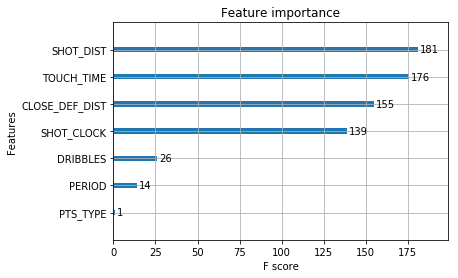

In [20]:
model = xgb.XGBClassifier()
model.fit(newdata,target)
xgb.plot_importance(model, importance_type = 'weight')
plt.show()

## Create optimized dataset

In [21]:
optdata = newdata[['SHOT_DIST', 'TOUCH_TIME', 'CLOSE_DEF_DIST', 'SHOT_CLOCK']]

## Running the models

**XGBoost**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(optdata, target, train_size=0.70, test_size = 0.3, random_state=42)

In [23]:
xgbmodel = xgb.XGBClassifier().fit(X_train,y_train)
predicted = xgbmodel.predict(X_test)
actual = y_test

print(precision_score(actual, predicted))

0.6450558123802007


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



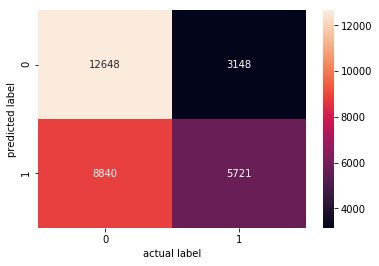

In [24]:
confusion = confusion_matrix(actual, predicted)
sns.heatmap(confusion, annot=True, fmt='d')
plt.xlabel('actual label')
plt.ylabel('predicted label')
plt.show()

**KNeighbors**

In [25]:
knmodel = KNeighborsClassifier().fit(X_train, y_train)
predicted = knmodel.predict(X_test)
actual = y_test

print(precision_score(actual, predicted))

0.5438492357916604


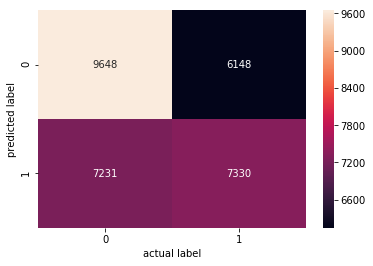

In [26]:
confusion = confusion_matrix(actual, predicted)
sns.heatmap(confusion, annot=True, fmt='d')
plt.xlabel('actual label')
plt.ylabel('predicted label')
plt.show()

**Random Forest**

In [27]:
rfmodel = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train, y_train)
predicted = rfmodel.predict(X_test)
actual = y_test

print(precision_score(actual, predicted))

0.562443401662962


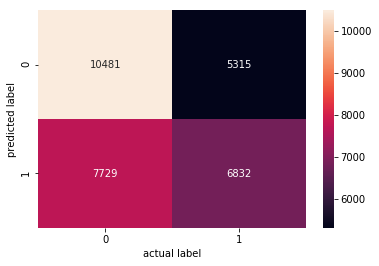

In [28]:
confusion = confusion_matrix(actual, predicted)
sns.heatmap(confusion, annot=True, fmt='d')
plt.xlabel('actual label')
plt.ylabel('predicted label')
plt.show()

## **Conclusion**

* XGB Classifier model does the best job of predicting the data 
* Low $R^2$ values can be explained: 
    * One or more metrics affect the result of the shot, but haven't been incorporated 
* Future Improvement
    * Plot importance check on all metrics